In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import torch
import seaborn as sns

In [3]:
train_path = 'Results_population/train_metrics'
file_list = os.listdir(train_path)
datasets = file_list
datasets

['fulsang_data', 'jaulab_data']

In [29]:
# SELECT THE DATASET
dataset = datasets[0]

In [30]:
ds_subjects = {'fulsang': ['S'+str(n+1) for n in range(18)], 'jaulab': ['S'+str(n+1) for n in range(17)]}
subjects = ds_subjects[dataset.split('_')[0]]

In [31]:
train_metrics = {}
models = ['FCNN', 'CNN']
sets = ['train', 'val']

key = '02_08'

for model in models:
    for set in sets:
        path = os.path.join(train_path, dataset, set, model+'_'+key)
        file_list = os.listdir(path)
        train_metrics[model+'_'+set] = {}
        for file in file_list:
            for subj in subjects:
                if subj in file:
                    if subj == 'S1':
                        idx = file.index(subj)
                        if file[idx+2] == '_': # si el siguiente caracter al S1 es un barra baja añade al diccionario    
                            loss = json.load(open(os.path.join(path,file), 'r'))
                            train_metrics[model+'_'+set][subj] = loss
                    else:   
                        loss = json.load(open(os.path.join(path,file), 'r'))
                        train_metrics[model+'_'+set][subj] = loss

epocas = len(train_metrics['FCNN_train']['S1'])
print(f'Epocas {epocas}')               

Epocas 53


In [32]:
def get_subject(n, n_subject):
    subjects = ['S'+str(i+1) for i in range(n_subject)]
    return subjects[n]

1


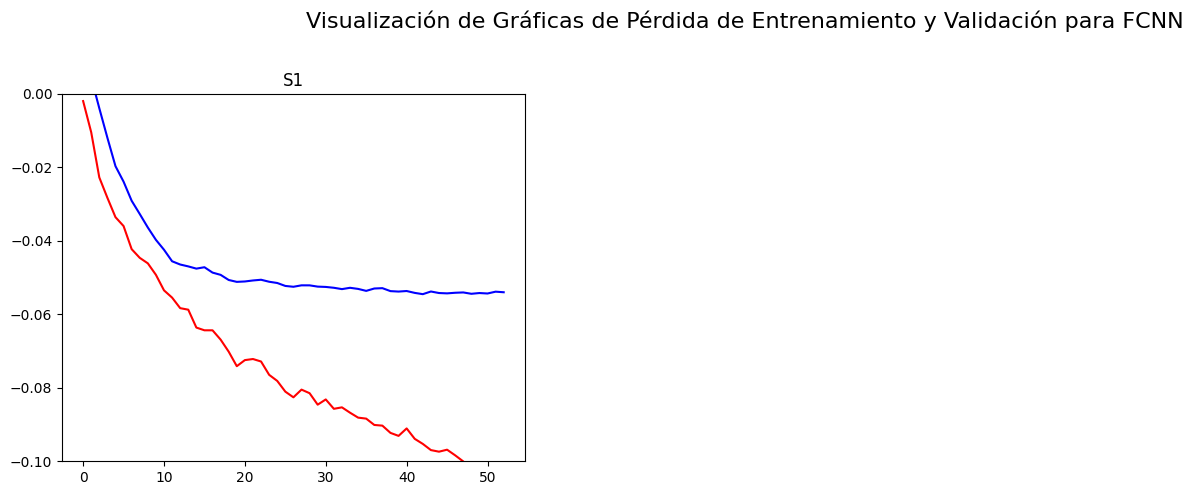

In [34]:
# Seleccionar FCNN o CNN
mode = 'FCNN'
n_subj = len(train_metrics[mode+'_val'])
print(n_subj)

n_plots = n_subj

# Calcular el número de filas necesarias
n_rows = (n_plots + 2) // 3

# Creo la figura y una matriz de subfiguras
fig, axs = plt.subplots(nrows=n_rows, ncols=3, figsize=(15, 5 * n_rows))

# Aplanar la matriz de subfiguras para un acceso fácil
axs = axs.flatten()

idx = 0
for n in range(n_subj):
    subj = get_subject(n, n_subj)
    train_loss = torch.tensor(train_metrics[mode+'_train'][subj])
    val_loss = torch.tensor(train_metrics[mode+'_val'][subj])
    x = range(len(val_loss))
    
    axs[idx].plot(x, -train_loss, linestyle = '-', color='r')
    axs[idx].plot(x, -val_loss, linestyle = '-', color= 'b')
    axs[idx].set_ylim(-0.1, 0)
    axs[idx].set_title(subj)
    idx += 1

# Eliminar subfiguras vacías si hay menos subfiguras que lugares en la cuadrícula
for ax in axs[idx:]:
    fig.delaxes(ax)

plt.tight_layout()
# Agregar un título general a la figura
fig.suptitle('Visualización de Gráficas de Pérdida de Entrenamiento y Validación para '+ mode, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Ajustar el layout para dejar espacio para el título

plt.show()